# Lab 3

## Data Process

In [129]:
import pandas as pd
import numpy as np
df=pd.read_csv("train.dat", header=None , names=[i for i in range(41)], encoding='utf-8')
data=np.array(df)
x=data[:,0:40]
y=data[:,40:41]
y=np.squeeze(y)
Num=y.size
traning_rate=0.7
test_rate=0.3
x_training_data=x[0:int(traning_rate*Num),:]
y_trainning_data=y[0:int(traning_rate*Num)]
x_test_data=x[int(traning_rate*Num):Num,:]
y_test_data=y[int(traning_rate*Num):Num]

## Regression Tree

In [130]:
class RegressionTree(object):
    class Node(object):
        #节点
        def __init__(self, feature_index: int = None, feature_value=None, w=None, obj=None,
                     left_child_node=None, right_child_node=None, num_sample: int = None):
            """
            :param feature_index: 特征id
            :param feature_value: 特征取值
            :param w: 预测值
            :param obj: 得分
            :param left_child_node: 左孩子结点
            :param right_child_node: 右孩子结点
            :param num_sample:样本量
            """
            self.feature_index = feature_index
            self.feature_value = feature_value
            self.w = w
            self.obj = obj
            self.left_child_node = left_child_node
            self.right_child_node = right_child_node
            self.num_sample = num_sample

        def traversal(self):
            #遍历，返回所有叶子节点权重
            if  not self.left_child_node and not self.right_child_node:
                return [self.w]
            elif self.left_child_node and not self.right_child_node:
                return self.left_child_node.traversal()
            elif not self.left_child_node and self.right_child_node:
                return self.right_child_node.traversal()
            else:
                return self.left_child_node.traversal()+ self.right_child_node.traversal()


    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, gamma=1e-2, lamb=1e-3,min_gain=0):
        """
        :param max_depth:树的最大深度
        :param min_samples_split:当对一个内部结点划分时，要求该结点上的最小样本数，默认为2
        分配到的样本数目小于该值停止分化
        :param min_samples_leaf:设置叶子结点上的最小样本数，默认为1
        :param gamma:罚项中的gamma
        :param lamb:即损失函数中lambda
        :param min_gain:划分增益阈值
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.gamma = gamma
        self.lamb = lamb
        self.min_gain=min_gain

    def _obj(self, g, h):
        #g为一阶导数数组，h为二阶导数数组，计算obj（obj）
        G = np.sum(g)
        H = np.sum(h)
        return -0.5 * G ** 2 / (H + self.lamb) + self.gamma

    def _build_tree(self, current_depth, current_node: Node, x, g, h):
        #递归调用构造树
        rows, cols = x.shape
        # 计算G和H
        G = np.sum(g)
        H = np.sum(h)
        # 计算当前的预测值
        current_node.w = -1 * G / (H + self.lamb)
        current_node.num_sample = rows
        # 判断停止切分的条件
        current_node.obj = self._obj(g, h)

        if rows < self.min_samples_split:
            #分配到的样本数目小于某个阈值停止分化
            return

        if self.max_depth is not None and current_depth > self.max_depth:
            #超过了允许的最大深度
            return


        best_index = None
        best_index_value = None
        # 根据得分选择最大增益的最佳的特征以及取值
        best_criterion_value = self.min_gain
        #get_best_split
        for index in range(0, cols):
            #对index列遍历
            for index_value in sorted(set(x[:, index])):
                #feature 提取出来并升序排列
                #对数据行遍历
                left_indices = np.where(x[:, index] <= index_value)
                right_indices = np.where(x[:, index] > index_value)
                delta_obj = current_node.obj - self._obj(g[left_indices], h[left_indices]) - self._obj(
                    g[right_indices], h[right_indices])
                #计算增益
                if delta_obj > best_criterion_value:
                    best_criterion_value = delta_obj
                    best_index = index
                    best_index_value = index_value

        if best_index is None:
            # 如果增益小于min_gain则停止划分
            return
        # 切分
        current_node.feature_index = best_index
        current_node.feature_value = best_index_value
        selected_x = x[:, best_index]

        # 创建左孩子结点
        left_selected_index = np.where(selected_x <= best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(left_selected_index[0]) >= self.min_samples_leaf:
            left_child_node = self.Node()
            current_node.left_child_node = left_child_node
            self._build_tree(current_depth + 1, left_child_node, x[left_selected_index], g[left_selected_index],
                             h[left_selected_index])
        # 创建右孩子结点
        right_selected_index = np.where(selected_x > best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(right_selected_index[0]) >= self.min_samples_leaf:
            right_child_node = self.Node()
            current_node.right_child_node = right_child_node
            self._build_tree(current_depth + 1, right_child_node, x[right_selected_index], g[right_selected_index],
                             h[right_selected_index])

    def fit(self, x, g, h):
        # 构建空的根节点
        self.root_node = self.Node()
        # 递归构建树
        self._build_tree(1, self.root_node, x, g, h)
    # 检索叶子节点的结果
    def _search_node(self, current_node: Node, x):
        if current_node.left_child_node is not None and x[current_node.feature_index] <= current_node.feature_value:
            return self._search_node(current_node.left_child_node, x)
        elif current_node.right_child_node is not None and x[current_node.feature_index] > current_node.feature_value:
            return self._search_node(current_node.right_child_node, x)
        else:
            return current_node.w


    def penalty(self):
        pen=0
        w=self.root_node.traversal()
        w=np.array(w)
        return  0.5*self.lamb*sum(w**2)+self.gamma*w.size
        
    def predict(self, x):
        # 计算结果
        # x = self.dbw.transform(x)
        rows = x.shape[0]
        results = []
        for row in range(0, rows):
            results.append(self._search_node(self.root_node, x[row]))
        return np.asarray(results)

## XGboost

In [131]:
import matplotlib.pyplot as plt
class XGboost(object):
    def __init__(self, base_estimator=None, n_estimators=10,Obj=0):
        """
        :param base_estimator: 基学习器
        :param n_estimators: 基学习器迭代数量
        :param Obj:树的总得分
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        if self.base_estimator is None:
            #初始化基学习器
            self.base_estimator = [RegressionTree(lamb=1e-7,gamma=1e-9,max_depth=4) for _ in range(self.n_estimators)]
        self.Obj=Obj

    def _get_gradient_hess(self, y, y_pred):
        #返回一阶导、二阶导信息
        return y_pred - y, np.ones_like(y)

    def fit(self, x, y):
        y_pred = np.zeros_like(y)
        g, h = self._get_gradient_hess(y, y_pred)
        penalty_current=0
        Obj_current =0.0
        times=np.arange(1,self.n_estimators+1)
        Objs=np.array([])
        for index in range(0, self.n_estimators):
            self.base_estimator[index].fit(x, g, h)
            penalty_current+=self.base_estimator[index].penalty()
            y_pred += self.base_estimator[index].predict(x)
            Obj_current = sum((y_pred - y)**2) #loss
            Objs=np.append(Objs,Obj_current) #这是赋值的，不是引用
            g, h = self._get_gradient_hess(y, y_pred)
        self.Obj= Obj_current
        #可视化
        plt.title('The number of base learners—loss curve ')
        plt.xlabel("The number of base learners")
        plt.ylabel("loss")
        plt.plot(times,Objs)
        plt.show()

    def predict(self, x):
        result=np.zeros_like(x[:,0])
        for index in range(self.n_estimators):
            result=result+self.base_estimator[index].predict(x)
        return result

    def evaluate(self,y_real,y_predict):
        rmse=sum((y_real-y_predict)*(y_real-y_predict))
        rmse=pow(rmse/y_real.size,0.5)
        print('RMSE=',rmse)
        return rmse

## Test(best model)

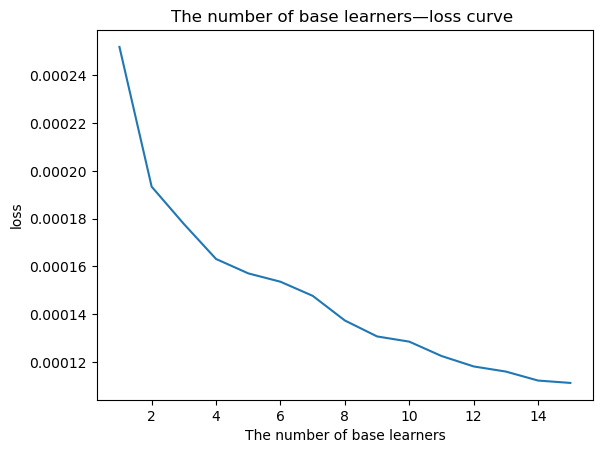

RMSE= 0.00018789335527137155


0.00018789335527137155

In [133]:
model = XGboost(n_estimators=15)
model.fit(x_training_data, y_trainning_data)
y_predict=model.predict(x_test_data)
model.evaluate(y_test_data,y_predict)

## Comparison

In [ ]:
nums=[5,10,15,20,25]
for n_estimators in nums :
    base_estimator = [RegressionTree(lamb=1e-7,gamma=1e-9,max_depth=4) for _ in range(n_estimators)]
    model = XGboost(n_estimators=n_estimators,base_estimator=base_estimator)
    model.fit(x_training_data, y_trainning_data)
    y_predict=model.predict(x_test_data)
    model.evaluate(y_test_data,y_predict)


In [ ]:
gammas=[1e-3,1e-5,1e-7,1e-9,1e-11]
for gamma in gammas :
    base_estimator = [RegressionTree(lamb=1e-7,gamma=gamma,max_depth=4) for _ in range(10)]
    model = XGboost(n_estimators=10,base_estimator=base_estimator)
    model.fit(x_training_data, y_trainning_data)
    y_predict=model.predict(x_test_data)
    model.evaluate(y_test_data,y_predict)

In [ ]:
lams=[1e-3,1e-5,1e-7,1e-9,1e-11]
for lamb in lams :
    base_estimator = [RegressionTree(lamb=lamb,gamma=1e-9,max_depth=4) for _ in range(10)]
    model = XGboost(n_estimators=10,base_estimator=base_estimator)
    model.fit(x_training_data, y_trainning_data)
    y_predict=model.predict(x_test_data)
    model.evaluate(y_test_data,y_predict)

In [ ]:
depth=[3,5,8,12,15]
for max_depth in depth :
    base_estimator = [RegressionTree(lamb=1e-7,gamma=1e-9,max_depth=max_depth) for _ in range(4)]
    model = XGboost(n_estimators=4,base_estimator=base_estimator)
    model.fit(x_training_data, y_trainning_data)
    y_predict=model.predict(x_test_data)
    model.evaluate(y_test_data,y_predict)